In [1]:
import os
import sys
import os.path as osp
import random
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [2]:
# plt.show()  不执行下行代码，程序会崩溃
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [3]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
def make_datapath_list(rootpath):
    """_summary_
        创建一个列表变量，用来保存图像数据和标注数据的文件路径
    Args:
        rootpath (_type_): str数据文件夹的路径
    Returns:
        train_img_list , train_anno_list, val_img_list, val_anno_list
    """
    
    # 创建图像文件与标注文件的路径模板
    imgpath_template = os.path.join(rootpath,'JPEGImages','%s.jpg') 
    annopath_template = os.path.join(rootpath,'Annotations','%s.xml')
    
    # 分别取得训练和验证用的文件的ID
    train_id_names = osp.join(rootpath+'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath+'ImageSets/Main/val.txt')

    # 创建训练数据的图像文件与标注文件的路径列表
    train_img_list = list()
    train_anno_list = list()
    
    
    for line in open(train_id_names):
        file_id = line.strip() # 删除空格和换行符号
        img_path = (imgpath_template % file_id) # 图像的路径 
        anno_path = (annopath_template % file_id) # 标注的路径
        
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)
    
    val_img_list = list()
    val_anno_list = list()
    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)
    
    return train_img_list,train_anno_list,val_img_list,val_anno_list    
        

rootpath = r'../0_datasets/2_VOC2012/VOCdevkit/VOC2012/'
train_img_list,train_anno_list,val_img_list,val_anno_list = make_datapath_list(rootpath)
print(train_img_list[0])
print(train_anno_list[0])

../0_datasets/2_VOC2012/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg
../0_datasets/2_VOC2012/VOCdevkit/VOC2012/Annotations/2008_000008.xml


In [5]:
# 标注数据是用.xml数据保存的，需要解析为python列表
class Anno_xml2list(object):
    def __init__(self,classes):
        self.classes = classes
        
    def __call__(self, xml_path,width,height):
        """_summary_

        Args:
            xml_path (_type_): _description_
            width (_type_): _description_
            height (_type_): _description_

        Returns:
            _type_: 返回每个标注物体的 坐标信息（4个）+1个label
        """
        result = []
        xml = ET.parse(xml_path).getroot()
        
        # 将图像包含的物体的标注保存到列表中
        for obj in xml.iter('object'):
            # 将标注中，注明困难识别的物体剔除
            difficult = int(obj.find('difficult').text)
            if difficult ==1:
                continue
            
            # 用于保存每个物体的标注信息
            bndbox = []
            
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
            
            # 获取标注的 xmin ymin xmax ymax，并归一化0~1
            pts = ['xmin','ymin','xmax','ymax']
            
            for pt in pts:
                # 由于标注VOC的原点是（1，1）开始，因此减1变为（0，0）
                cur_pixel = int(bbox.find(pt).text)-1
                
                #使用高度、宽度正则化
                if pt == 'xmin' or pt=='xmax':
                    cur_pixel/=width
                else:
                    cur_pixel/=height
                    
                bndbox.append(cur_pixel)
            
            # 取得标注的分类的index并添加
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)  # bndbox现在有五个元素：xmin，ymin,xmax,ymax,label_idx
            
            # 将bndbox添加到result
            result+=[bndbox]
        return np.array(result)            
            
                    

In [6]:
# 测试 xml解析结果
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

# 使用opencv读取图像
transform_anno = Anno_xml2list(voc_classes)
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)

height,width, channels = img.shape
transform_anno(val_anno_list[ind],width,height)



array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

In [7]:
# 创建 DataTransform类
from utils.data_argumentation import Compose,ConvertFromInts,ToAbsoluteCoords,PhotometricDistort,Expand,RandomSampleCrop,RandomMirror,ToPercentCoords,Resize,SubtractMeans

class DataTransform():
    """
        图像和标注的预处理类，训练和预测采用不同的处理方法
        将图像尺寸调整为300*300 pix
        学习时，进行数据增强处理
    """
    def __init__(self,input_size,color_mean) -> None:
        """

        Args:
            input_size (_type_): 需要调整的图像大小
            color_mean (_type_): 各个颜色通道的平均值
        """
        self.data_transform={
            'train':Compose([
                ConvertFromInts(), # 将int转为float32
                ToAbsoluteCoords(), # 返回标准化后的标注数据
                PhotometricDistort(), #随机的调整图像的色调
                Expand(color_mean), # 扩展图像画布尺寸
                RandomSampleCrop(), # 随机的截图图片部分内容
                RandomMirror() , #对图像进行反转
                ToPercentCoords(), # 将标注数据进行归一化，0~1
                Resize(input_size), # 调整图像尺寸
                SubtractMeans(color_mean) # 减去RGB的平均值
            ]),
            'val':Compose([
                ConvertFromInts(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ])
        }
        
    def __call__(self, img,phase,boxes,labels) :
        return self.data_transform[phase](img,boxes,labels)

(442, 500, 3)


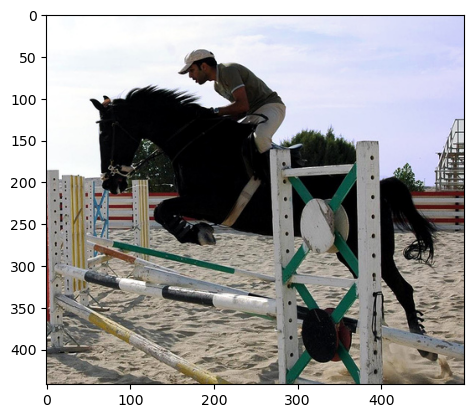

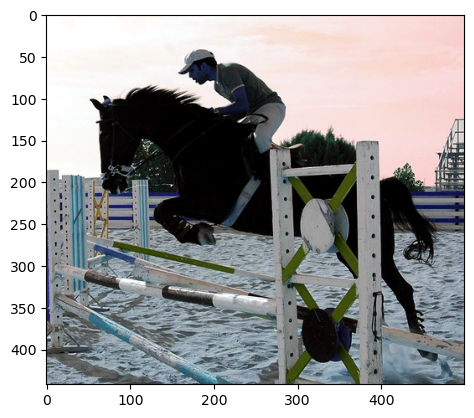

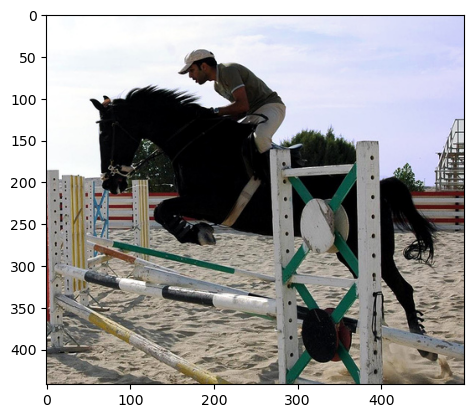

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


================= 以下显示预处理后的 train vla图像============
(0.1, None)


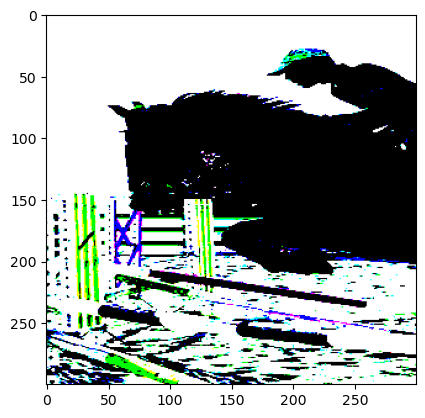

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


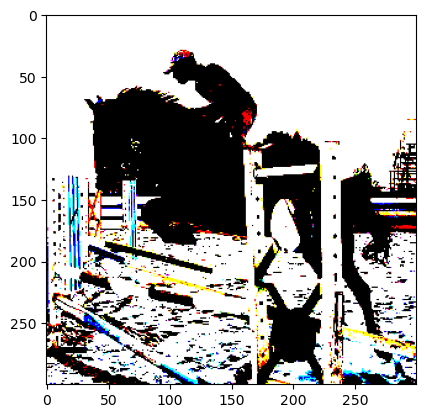

In [8]:
# 测试预处理类
# 1. 读取图像
image_file_path_t = train_img_list[0]
img = cv2.imread(image_file_path_t)  # 高度、宽度、GBR(Opencv 读取的图片是BGR 矩阵：)
print(img.shape)
height,width,channels = img.shape

# 2. 读取标注信息
transform_anno_t = Anno_xml2list(voc_classes)
img_anno_list = transform_anno_t(train_anno_list[0],width,height)

# 3.显示原始图像
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) # RGB
plt.show()
 
plt.imshow(img) # (Opencv 读取的图片是BGR 矩阵：),显示的是BGR通道
plt.show()

plt.imshow(img[:,:,(2,1,0)]) #  由于颜色通道是 BGR，需要转为RGB 
plt.show()

print('================= 以下显示预处理后的 train vla图像============')

# 4. 创建预处理类
color_mean = (104,117,123) # RGB颜色的平均值
input_size = 300
transform_t = DataTransform(input_size,color_mean)

# 5. 显示处理后的图像 train
phase = 'train'
img_transformed,boxes,labels = transform_t(img,phase,img_anno_list[:,:4],img_anno_list[:,4])
plt.imshow(cv2.cvtColor(img_transformed,cv2.COLOR_BGR2RGB))
plt.show()

# 6. 显示val图像
phase = 'val'
img_transformed,boxes,labels = transform_t(img,phase,img_anno_list[:,:4],img_anno_list[:,4])
plt.imshow(img_transformed)
plt.show()

In [9]:
# 创建DataSet
from torch.utils.data import Dataset,DataLoader
class VOC2012Dataset(Dataset):
    def __init__(self,img_list,anno_list,phase,transform,transform_anno):
        """_summary_

        Args:
            img_list (_type_): 保存图像的列表
            anno_list (_type_): 保存标注数据的列表
            phase (_type_): train or val
            transform (_type_): object 预处理类的实例
            transform_anno (_type_): object 将xml类型的标注文件转为list的实例
        """
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,index):
        im,gt,h,w =  self.pull_item(index)
        #  # gt 是BBox和标签的组合体
        return im,gt
    
    def pull_item(self,index):
        # 1. 读取图像
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)
        height,width,channels = img.shape
        
        # 2. 将xml转为list
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path,width,height)
        
        # 3. 预处理 
        img,boxes,labels = self.transform(img,self.phase,anno_list[:,:4],anno_list[:,4])
        
        # 由于颜色通道是 BGR，需要转为RGB ，然后将 高度、宽度，颜色通道 转为颜色通道、高度，宽度
        img = torch.from_numpy(img[:,:,(2,1,0)]).permute(2,0,1)
        gt = np.hstack((boxes,np.expand_dims(labels,axis=1)))  # gt 是BBox和标签的组合体
        
        return img,gt,height,width
    
# 测试
color_mean = (104,117,123)
input_size = 300
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor'] # 20类型
train_dataset = VOC2012Dataset(train_img_list,train_anno_list,phase='train',transform=DataTransform(input_size,color_mean),transform_anno=Anno_xml2list(voc_classes))
val_dataset = VOC2012Dataset(val_img_list,val_anno_list,phase='val',transform=DataTransform(input_size,color_mean),transform_anno=Anno_xml2list(voc_classes))

val_one = val_dataset.__getitem__(1)
print(val_one[0].shape)
print(val_one[1].shape)
print(val_one[1])




torch.Size([3, 300, 300])
(2, 5)
[[ 0.09        0.03003003  0.998       0.996997   18.        ]
 [ 0.122       0.56756757  0.164       0.72672673 14.        ]]


In [10]:
# dataset返回的是每个图像中物体的标注信息，不同图像的返回的信息大小不一致
# 需要对DataLoader类的collate_fn进行重新定义 od表示object-detection
def od_collate_fn(batch):
    """_summary_
    collate_fn是pytorch从列表中创建小批次数据的函数
    Args:
        batch (_type_): 
    """
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(torch.FloatTensor(sample[1])) # gt
    
    # 3维的凑成一个4维的张量…以此类推，也就是在增加新的维度进行堆叠。([3, 300, 300])
    imgs = torch.stack(imgs,dim=0) # 沿着一个新维度对输入张量序列进行连接([1,3, 300, 300])
    return imgs,targets
    
    

In [11]:
batch_size = 4
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=od_collate_fn)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True,collate_fn=od_collate_fn)

dataloaders_dict = {'train':train_dataloader,'val':val_dataloader}
imgs,targets = next(iter(dataloaders_dict['val']))
print(imgs.size())
print(len(targets))
print(targets[1].size())

tt = [x.numpy().tolist() for x in targets]
merage_target = sum(tt,[])
print(np.array(merage_target).shape)

torch.Size([4, 3, 300, 300])
4
torch.Size([1, 5])
(5, 5)


In [12]:
print(train_dataset.__len__()) # alt+shift+下键 复制当前行到下一行
print(val_dataset.__len__())

5717
5823
